In [1]:
import pandas as pd
from sklearn.metrics import mean_squared_error
from math import sqrt
import plotly.express as px
import plotly.figure_factory as ff
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
import warnings

# Create validation dataset
Withhold the last one year of data from analysis and model selection. This final year of data will be used to validate the final model. The validation dataset will be 10% of the original dataset.

In [2]:
series = pd.read_csv('datasets/robberies.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
split_point = len(series) - 12
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('datasets/robberies/dataset.csv', header=False)
validation.to_csv('datasets/robberies/validation.csv', header=False)

Dataset 106, Validation 12


# Model Evaluation
Candidate models are evaluated using walk-forward validation. 

First 50% of dataset is used to train the model. The remaining 50% of the dataset is iterated and used to test the model. At each iteration, a model is trained and a one step prediction made and stored for later evaluation. Actual observation from test dataset is added to the training dataset for the next iteration. Predictions made during iteration are scored using RMSE.

In [3]:
X_series = pd.read_csv('datasets/robberies/dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
X = X_series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

In [4]:
# walk-forward validation for persistence model
def persistence_model(history):
    return history[-1]

def evaluate_model(model):
    history = [x for x in train]
    predictions = list()
    for i in range(len(test)):
        yhat = model(history)
        predictions.append(yhat)
        obs = test[i]
        history.append(obs)
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [5]:
rmse = evaluate_model(persistence_model)
print('RMSE: %.3f ' % rmse)

RMSE: 51.844 


## Data Analysis
Use summary statistics and plots of the data to learn about the structure of the prediction problem.

### Summary Statistics
Standard deviation is relatively large at 112 robberies. There is a large spread to the data.

In [6]:
print(X_series.describe())

count    106.000000
mean     173.103774
std      112.231133
min       29.000000
25%       74.750000
50%      144.500000
75%      271.750000
max      487.000000
Name: 1, dtype: float64


### Line Plot
Increasing trend of robberies over time. Large fluctuations year to year especially in later years. Dataset is non-stationary. Might benefit from removing the trend from time series. Alternatively, use differencing to make it stationary for modeling. 

In [7]:
fig = px.line(X_series, title='Line plot of Boston Robberies dataset', labels={'0': 'Year', 'value': 'Number of Robberies'})
fig.show()

### Density Plot
Distribution is not Gaussian. Distribution is left shifted and may be exponential or a double Gaussian.

In [8]:
fig = ff.create_distplot([X], group_labels=['Density'], bin_size=50, show_rug=False, curve_type='kde')
fig.show()

### Box and Whisker Plot
Median values for each year show a trend that may not be linear. Spread (middle 50%) of data differs over time. First two years are quite different. There might be benefit in clipping the first two years of data from modeling.

In [9]:
series = pd.read_csv('datasets/robberies/dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
groups = series.groupby(pd.Grouper(freq='A'))
years = {}
for name, group in groups:
    # Skip the last year as it only has 10 months and won't be useful in comparing with other years with 12 months of data
    if (name.year != 1974):
        years[name.year] = group.values
years_df = pd.DataFrame(data=years)
fig = px.box(years_df, labels={'variable': 'Year', 'value': 'Number of Robberies'})
fig.show()

# ARIMA Model

### Stationarity by differencing (d = 1)
Create a stationary version of the series and run adfuller test. Test statistic value -3.980946 is smaller than the critical value at 5%. Rejecting the null hypothesis means that process has no unit root, and the differenced time series is stationary.

In [10]:
def difference(dataset):
    diff = list()
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i-1]
        diff.append(value)
    return pd.Series(diff)

series = pd.read_csv('datasets/robberies/dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
X = series.values
stationary = difference(X)
stationary.index = series.index[1:]

In [11]:
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

stationary.to_csv('datasets/robberies/stationary.csv', header=False)

ADF Statistic: -3.980946
p-value: 0.001514
Critical Values:
	1%: -3.503
	5%: -2.893
	10%: -2.584


### Autoregression (p=11) and Moving Average (q=2)
ACF shows a significant lag for 10-11 months. PAcF shows a significant lag for perhaps 2 months. Both ACF and PACF show a drop-off at same point, suggesting a mix of AR and MA.

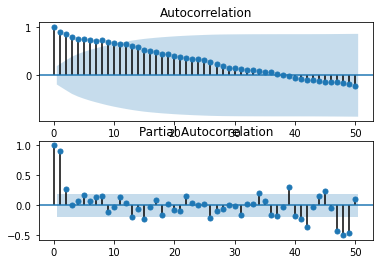

In [12]:
pyplot.figure()
pyplot.subplot(211)
plot_acf(series, lags=50, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(series, lags=50, ax=pyplot.gca())
pyplot.show()

### Evaluate manually configured ARIMA model
ARIMA configuration of (11,1,2) does not coverge and results in errors, so do similarly large AR values. After experimentation, model is not stable with non-zero AR and MA orders defined at the same time. Model can be simplified to (0,1,2)

In [ ]:
def ARIMA_model_with(order):
    def ARIMA_model(history):
        model = ARIMA(history, order=order)
        model_fit = model.fit(disp=0)
        return model_fit.forecast()[0]
    return ARIMA_model

rmse = evaluate_model(ARIMA_model_with((11,1,2)))
print('RMSE: %.3f ' % rmse)

### Grid search 

In [ ]:
def evaluate_models(p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_model(ARIMA_model_with(order))
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

# evaluate parameters
p_values = range(0,13)
d_values = range(0, 4)
q_values = range(0, 13)
warnings.filterwarnings("ignore")
evaluate_models(p_values, d_values, q_values)